In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [2]:
import pandas as pd
df = pd.read_csv("/content/IMDB Dataset.csv")

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,0
review,0
sentiment,0


In [4]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


::# Dataset Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

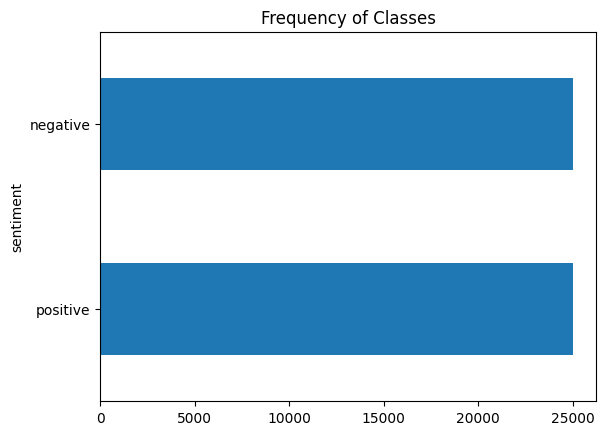

In [6]:
label_counts = df['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per review'}, xlabel='sentiment'>

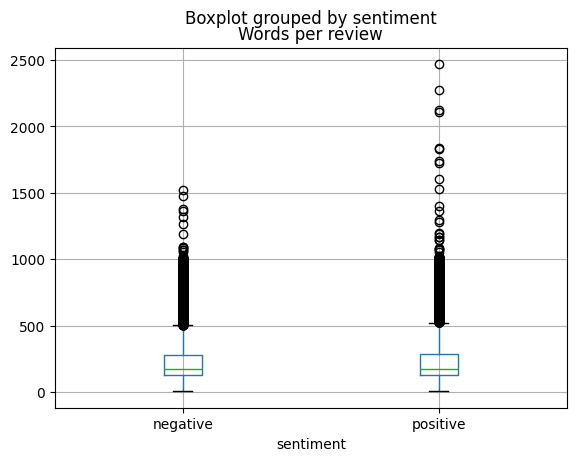

In [7]:
df['Words per review'] = df['review'].str.split().apply(len)
df.boxplot("Words per review", by="sentiment")

In [8]:
df['label']=df['sentiment'].map({'positive':1, 'negative':0})

#Text to Token Conversion

In [9]:
from transformers import AutoTokenizer

In [10]:
model_ckpt = "bert-base-uncased"  #ENGLISH english
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
len(tokenizer.vocab),tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

# Data Loader and Train Test Split

In [12]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])
train.shape, test.shape, validation.shape

((35000, 4), (10000, 4), (5000, 4))

In [13]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'Words per review', 'label'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'Words per review', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'Words per review', 'label'],
        num_rows: 5000
    })
})

#Tokenization of emotion/sentiment data

In [15]:
dataset['train'][0]

{'review': 'I\'m not quite sure why, but this movie just doesn\'t play the way it should. It should be humerous and fun, but instead is just boring. I think a large part of it is because they way over played the "gadgets." The old cartoon it is based on is much better.<br /><br />3/10',
 'sentiment': 'negative',
 'Words per review': 53,
 'label': 0}

In [16]:
def tokenize(batch):
    temp= tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True,)
    return temp

In [17]:
emotion_encoded=dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

#Model Building

In [18]:
from transformers import AutoModel
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch

In [45]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [47]:
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.48.0",
  "vocab_size": 30522
}

In [48]:
device = torch.device ("cuda" if torch. cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [50]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [51]:
from transformers import TrainingArguments

batch_size=32
training_dir = "distilbert-base-uncased-training-dir"
training_args= TrainingArguments(output_dir = training_dir,
              overwrite_output_dir = True,
              num_train_epochs = 2,
              learning_rate = 2e-5,
              per_device_train_batch_size = batch_size,
              per_device_eval_batch_size = batch_size,
              weight_decay = 0.01,
              evaluation_strategy = 'epoch',
              report_to="none",
              disable_tqdm = False
    )

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [52]:
! pip install evaluate

other than the above method, you can also use sklearn to calc accuracy

In [53]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics (pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [54]:
# train_data = train_data.map(tokenize, batched=True)
# val_data = val_data.map(tokenize, batched=True)

# train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
# val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

#Build Model and Trainer

In [55]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-55-f7f22c6f6a80>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.217100,0.184066,0.929000,0.928991
2,0.140300,0.186184,0.933400,0.933400


TrainOutput(global_step=2188, training_loss=0.1889814816183756, metrics={'train_runtime': 3357.9288, 'train_samples_per_second': 20.846, 'train_steps_per_second': 0.652, 'total_flos': 9272717905920000.0, 'train_loss': 0.1889814816183756, 'epoch': 2.0})

In [58]:
preds_output = trainer.predict(emotion_encoded[ 'test'])
preds_output.metrics

{'test_loss': 0.18914277851581573,
 'test_accuracy': 0.9358,
 'test_f1': 0.9357954697283439,
 'test_runtime': 154.5829,
 'test_samples_per_second': 64.69,
 'test_steps_per_second': 2.025}

In [59]:
preds_output.predictions

array([[ 2.3077452 , -2.1988173 ],
       [ 0.48836765, -0.49210015],
       [ 2.9391193 , -2.9977279 ],
       ...,
       [-2.4081204 ,  2.584122  ],
       [ 2.309793  , -2.3394287 ],
       [-2.6131423 ,  2.9654973 ]], dtype=float32)

In [61]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5000
           1       0.93      0.94      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



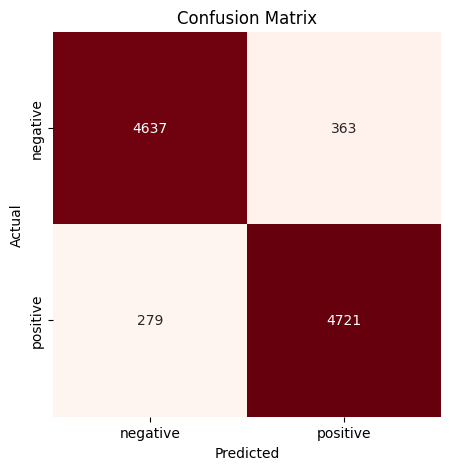

In [66]:
from sklearn.metrics import confusion_matrix # Import the confusion_matrix function
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels={'negative': 0, 'positive': 1}.keys(), yticklabels={'negative': 0, 'positive': 1}.keys(), fmt ='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.show()

#Build Prediction function and save model

In [90]:
text = "I am super happy today. I got it done. Finally!!"
def get_prediction (text) :
    input_encoded = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True).to(device)
    # Remove token_type_ids from the input_encoded dictionary
    input_encoded.pop('token_type_ids', None)
    with torch.no_grad():
      outputs = model(**input_encoded)
    logits = outputs. logits
    pred = torch.argmax(logits, dim=1) .item()
    return {0:'negative', 1:'positive'}[pred]
get_prediction (text)

'positive'

In [91]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [100]:
# use pipeline for prediction
from transformers import pipeline
classifier = pipeline('text-classification', model='/content/bert-base-uncased-sentiment-model')

# Modify the prediction call to exclude token_type_ids
def predict_with_classifier(texts):
    results = []
    for text in texts:
        # Tokenize the text and remove token_type_ids
        inputs = tokenizer(text, return_tensors='pt', truncation=True)
        inputs.pop('token_type_ids', None)

        # Move inputs to the appropriate device if necessary
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Perform inference
        with torch.no_grad():
            outputs = classifier.model(**inputs)  # Access underlying model

        # Get predicted label
        predicted_label_id = outputs.logits.argmax(-1).item()
        predicted_label = classifier.model.config.id2label[predicted_label_id]
        predicted_label={'LABEL_1':'positive','LABEL_0':'negative'}[predicted_label]
        # Append result
        results.append({'label': predicted_label, 'score': outputs.logits.softmax(-1).max().item()})
    return results

# Predict on the list of texts
predictions = predict_with_classifier([text, 'A very good day indeed', "We loved mth111", "I am feeling anxious"])
print(predictions)

Device set to use cuda:0


[{'label': 'positive', 'score': 0.9833852052688599}, {'label': 'positive', 'score': 0.9696645736694336}, {'label': 'positive', 'score': 0.8266815543174744}, {'label': 'negative', 'score': 0.6958097219467163}]


In [110]:
! pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
! streamlit run app.py & npx localtunnel --port 8501


34.143.230.56


⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.230.56:8501

⠹⠸⠼⠴⠦your url is: https://eager-insects-vanish.loca.lt
2025-01-19 11:54:28.902068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 11:54:28.926866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 11:54:28.934420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 11:54:30.305187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tens